# Google Colab 한글 폰트 설치

In [ ]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


- 테스트

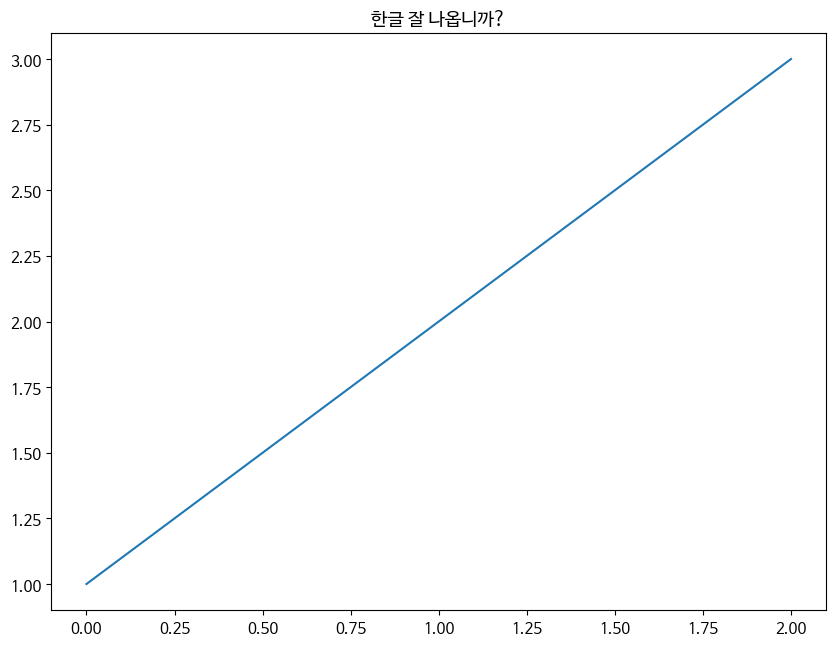

In [ ]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# Google Colab과 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 주요 라이브러리 및 환경설정

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 데이터 불러오기
- UCI 기계학습 Repo에서 사용할 수 있는 원본 데이터 집합의 단축 및 정리된 버전
- 2016년 9월 29일 오후 5시에 시작, 2019년 9울 30일 오후 11시에 끝.

In [ ]:
import pandas as pd
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/2024/알파코/time_series/data/"

train_df = pd.read_csv(DATA_PATH + 'train.csv', index_col=0)
val_df = pd.read_csv(DATA_PATH + 'val.csv', index_col=0)
test_df = pd.read_csv(DATA_PATH + 'test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


# 데이터 윈도우 시각화
- 훈련 집합 중 첫 400개의 시간 단계
- 각 데이터 윈도우는 24개의 시간 단계로 된 입력값과 24개의 시간 단계로 된 레이블로 구성

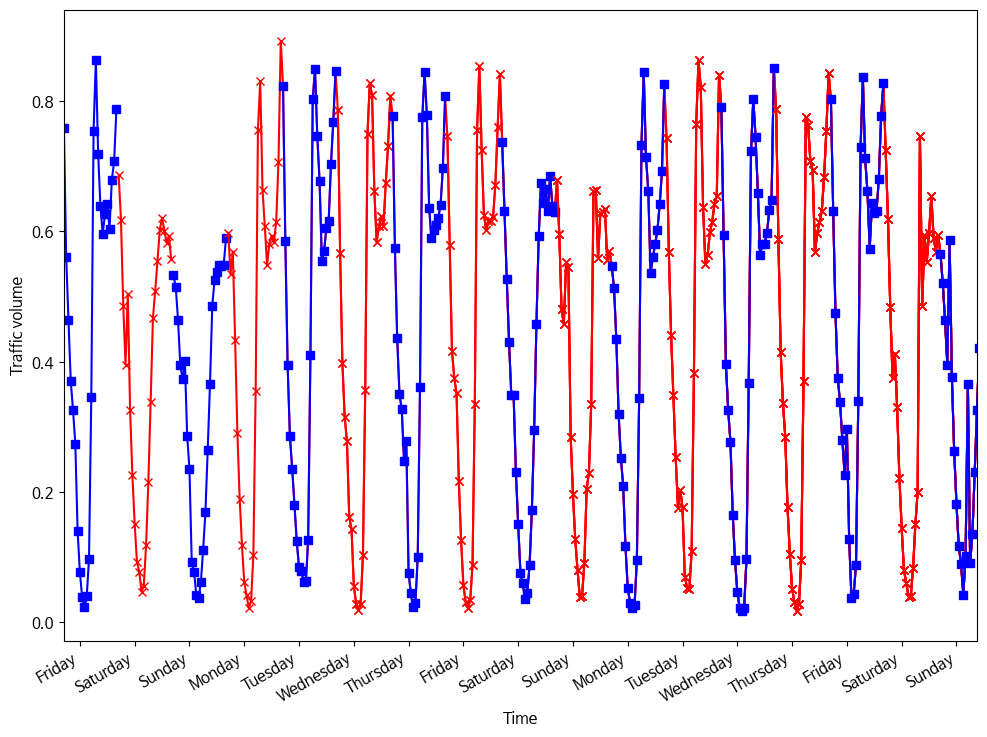

In [ ]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

# DataWindow 클래스
- 입력의 너비, 레이블의 너비, 이동(shift)을 기반으로 한다.
- 입력의 너비는 단순히 예측을 위해 모델에 입력되는 시간 단계의 개수
  + 24시간의 데이터 입력, 입력의 너비는 24
  + 12시간의 데이터 입력, 입력의 너비는 12
- 레이블의 너비 : 예측의 시간 단계 수와 동일
  + 하나의 시간 단계만 예측 : 레이블 너비 1
  + 하루 동안의 데이터를 예측하는 경우 레이블 너비 24
- 이동은 입력과 예측을 구분하는 시간 단계의 수
  + 다음 시간 단계를 예측하는 경우 이동의 너비는 1
  + 다음 24시간을 예측하는 경우 이동의 너비는 24

## split_to_inputs_labels 함수
- 데이터 윈도우 입력, 레이블, 두 개의 윈도우로 분리
- 큰 데이터 윈도우를 입력과 레이블, 두 개의 윈도우로 간단히 분리

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns # 예측하고자 하는 열의 이름
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} # 라벨 열의 이름과 색인으로 사전 만들기
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # 각 열의 이름과 인덱스로 사전 만들기, 특징을 분할.

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    # 데이터 윈도우의 샘플을 도식화하는 메서드
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10) #파란색 점선으로 표시

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)# 라벨 또는 실제값을 도식화, 녹색 사각형으로 표시
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index], # 예측을 도식화, 빨간 십자가로 표시.
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    # 주어진 데이터를 텐서플로에 맞게끔 변환하는 코드.
    # 텐서 변환
    #
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True, # 배열을 일괄적으로 섞는다.
            batch_size=32 # 32개의 배열로 구성했다.
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

# 베이스라인 모델 적용

## 단일 단계 베이스라인 모델
- 데이터 윈도우를 생성하는 것
- 단일 단계 모델 정의
- 다음 시간 단계 예측
  + 입력 너비 1, 레이블 너비 1, 이동 1
  + 목표 변수를 교통량

In [ ]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])

- 도식화를 위해 더 넓은 윈도우를 정의, 모델의 많은 예측 시각화
- 그렇지 않으면 하나의 입력 데이터 요소와 하나의 출력 예측만 시각화

In [ ]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

- 마지막으로 측정된 값

In [ ]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

- 열의 인덱스인 traffic_volume 찾아서 Baseline에 전달

### 평가 지표
- 손실 함수와 평가 지표 제공해야 한다는 점에 유의
- 평균제곱오차 손실 함수

In [ ]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['traffic_volume'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

- 검증 집합과 테스트 집합에서 베이스라인의 성능 평가

In [ ]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130 - mean_absolute_error: 0.0818


### 시각화
- 샘플 배치 중 세 개의 배열에 대한 단일 단계 베이스라인 모델에 의한 예측.
- 각 시간 단계의 예측은 마지막으로 측정된 값으로, 베이스라인이 예상대로 작동한다

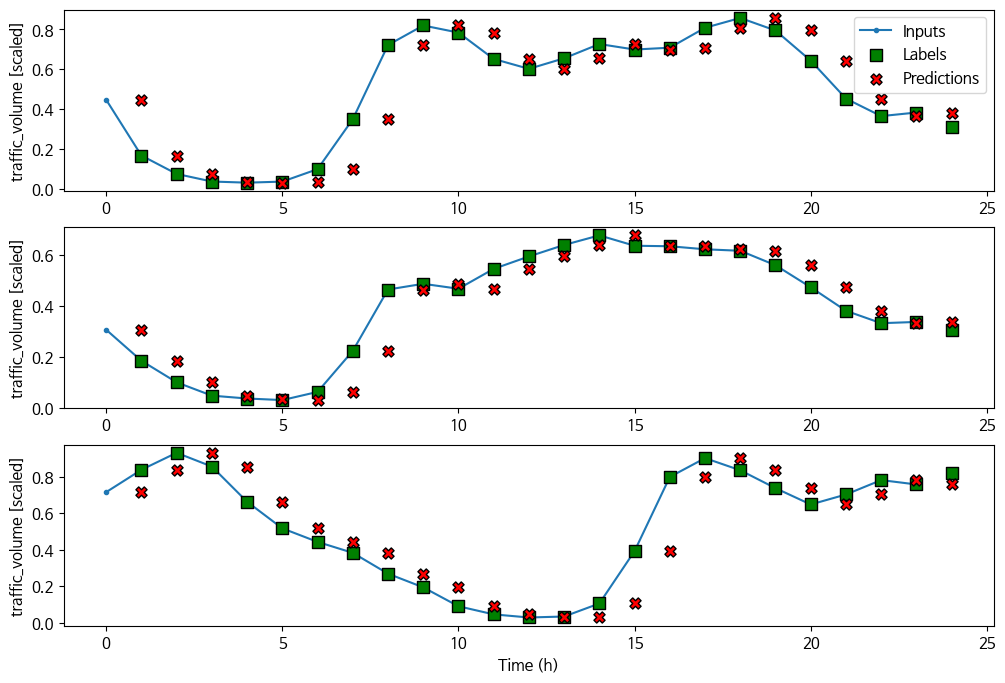

In [ ]:
wide_window.plot(baseline_last)
plt.show()

### 평가 지표 확인

In [ ]:
print(performance['Baseline - Last'][1])

0.08128398656845093


## 다중 단계 베이스라인 모델
- 하나 이상의 미래 시간 단계를 예측
- 24시간이 입력된 데이터의 다음 24시간 동안의 교통량 예측
- 24시간 입력 후, 미래의 24개 시간 단계 예측
- 입력 너비 24, 레이블 너비 24, 이동 너비 24

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

- 다음 24개 시간 단계에 대해 마지막으로 측정된 값으로 예측
- 다음 24개 시간 단계에 대해 마지막 24개 시간 단계로 예측

### 마지막으로 측정된 값으로 예측
- 입력 배열의 마지막 값을 24개의 시간 단계에 걸쳐 반복하는 MultiStepLastBaseline 클래스 정의

In [ ]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [ ]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1870 - mean_absolute_error: 0.3513


- 다음 24개의 시간 단계에 대해 마지막으로 측정된 값으로 예측

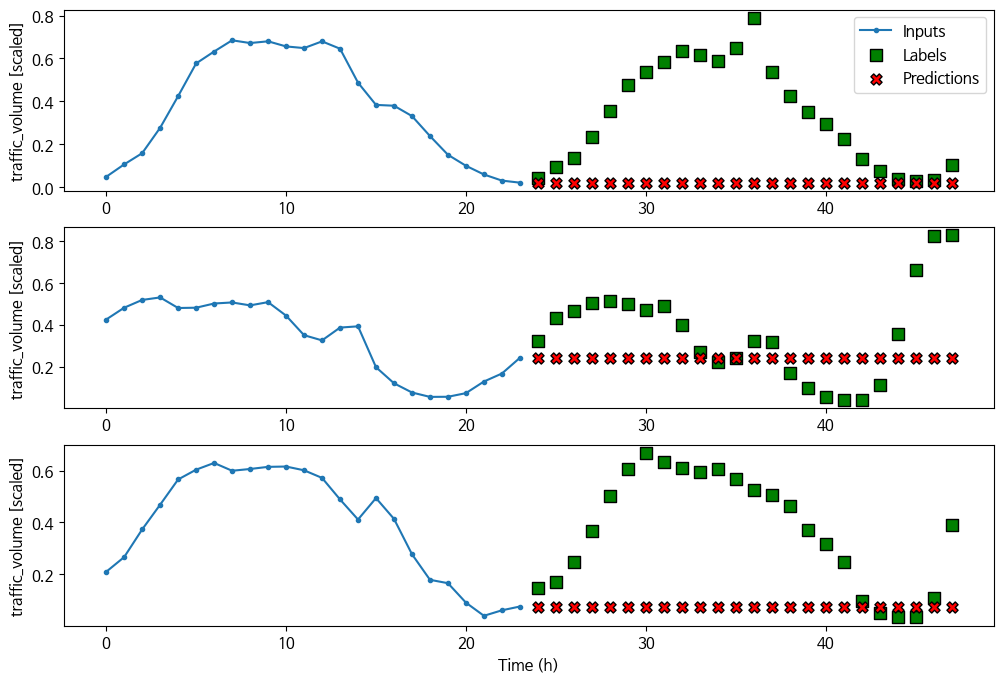

In [ ]:
multi_window.plot(ms_baseline_last)

- 평가지표 확인 결과 레이블과 예측 사이에 큰 불일치가 있음
- 따라서, MAE는 상당히 높게 나옴

In [ ]:
print(ms_performance['Baseline - Last'][1])

0.34706422686576843


### 입력 배열 반복
- 24시간 동안의 예측은 단순히 마지막으로 측정된 24시간 동안의 데이터가 됨

In [ ]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

- 베이스라인 모델 초기화 후 예측 생성
- 손실 함수와 평가 지표 동일하게 유지

In [ ]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2128 - mean_absolute_error: 0.3539


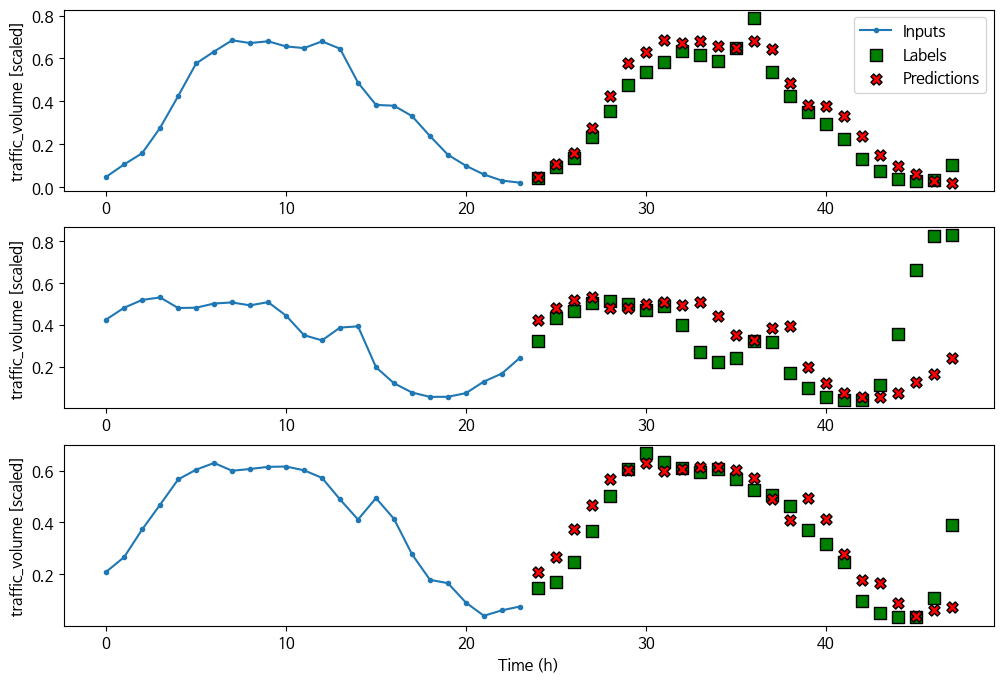

In [ ]:
multi_window.plot(ms_baseline_repeat)

- 테스트 집합에 대해 MAE 출력하면 단순히 마지막으로 측정된 값을 예측하는 것보다 더 나은 베이스라인 구축

In [ ]:
print(ms_performance['Baseline - Repeat'][1])

0.343904584646225


## 다중 출력 베이스라인 모델
- 다중 출력 모델 : 하나의 입력 데이터 요소 사용, 다음 시간 단계의 교통량과 온도 예측하고자 함

### 데이터 윈도우 정의
- 훈련용, 시각화용, 두 개의 윈도우 정의
- 하나의 데이터 포인트를 가져와 하나의 예측 출력
- 여러 시간 단계에 걸쳐 많은 예측 시각화

In [ ]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

- 마지막으로 측정된 값을 예측값으로 출력하기 위해 temp 및 traffic_volume 열의 인덱스 전달

In [ ]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


- 두 개의 목표 변수로 베이스라인 초기화

In [ ]:
mo_baseline_last = Baseline(label_index=[0, 2])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - mean_absolute_error: 0.0482


### 예측
- 교통량에 대해 마지막으로 측정된 값으로 예측

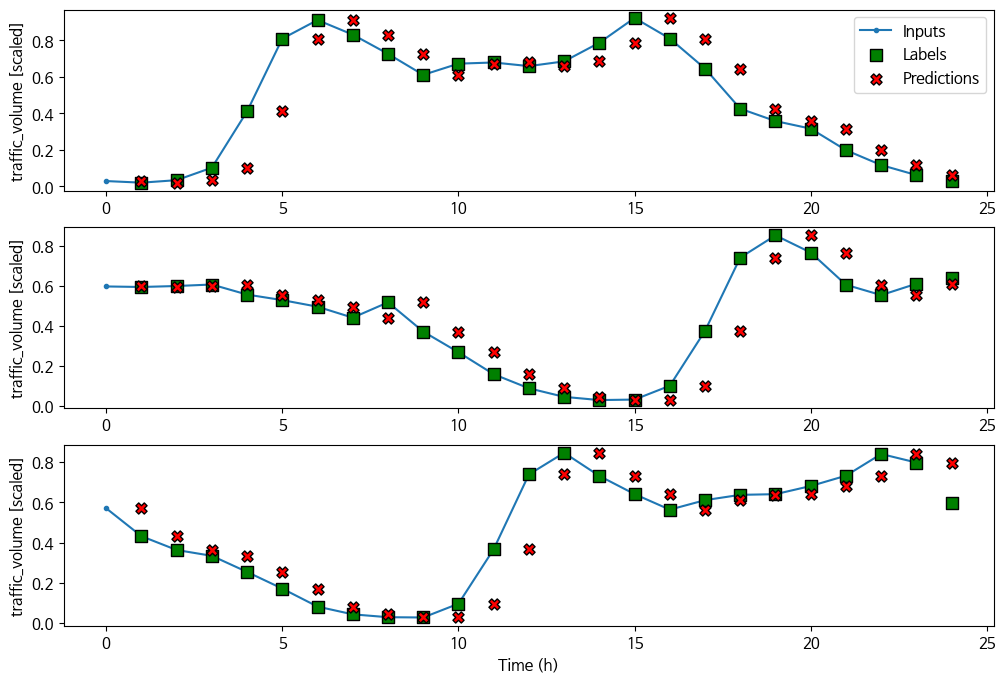

In [ ]:
mo_wide_window.plot(mo_baseline_last)

### 평가

In [ ]:
print(mo_performance['Baseline - Last'][1])

0.047106657177209854


# 딥러닝 모델 적용

## 단일 단계 선형 모델 구현
- 선형 모델은 실제로 훈련 필요
- 딥러닝 모델, DataWindow 클래스의 데이터 윈도우, patience 매개변수, max_epochs 매개변수 입력받기
- 케라스에서는 손실 함수, 옵이마이저 평가 지표 지정하여 모델 설정

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

### 모델 구축 및 학습
- 선형 모델 구축, 다음 시간 단계의 교통량 예측이라는 하나의 값만 출력
- units는 1로 지정

In [ ]:
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4077 - mean_absolute_error: 0.5518 - val_loss: 0.2442 - val_mean_absolute_error: 0.4269
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1928 - mean_absolute_error: 0.3746 - val_loss: 0.1150 - val_mean_absolute_error: 0.2878
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0882 - mean_absolute_error: 0.2458 - val_loss: 0.0529 - val_mean_absolute_error: 0.1914
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0407 - mean_absolute_error: 0.1599 - val_loss: 0.0271 - val_mean_absolute_error: 0.1343
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0217 - mean_absolute_error: 0.1121 - val_loss: 0.0172 - val_mean_absolute_error: 0.1038
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0149 - mean_absolute_error: 0.0902 - val_loss: 0.0133 - val_mean_absolute_error: 0.0883
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0123 - mean_absolute_error: 0.0805 - v

### 선형 모델 예측 시각화

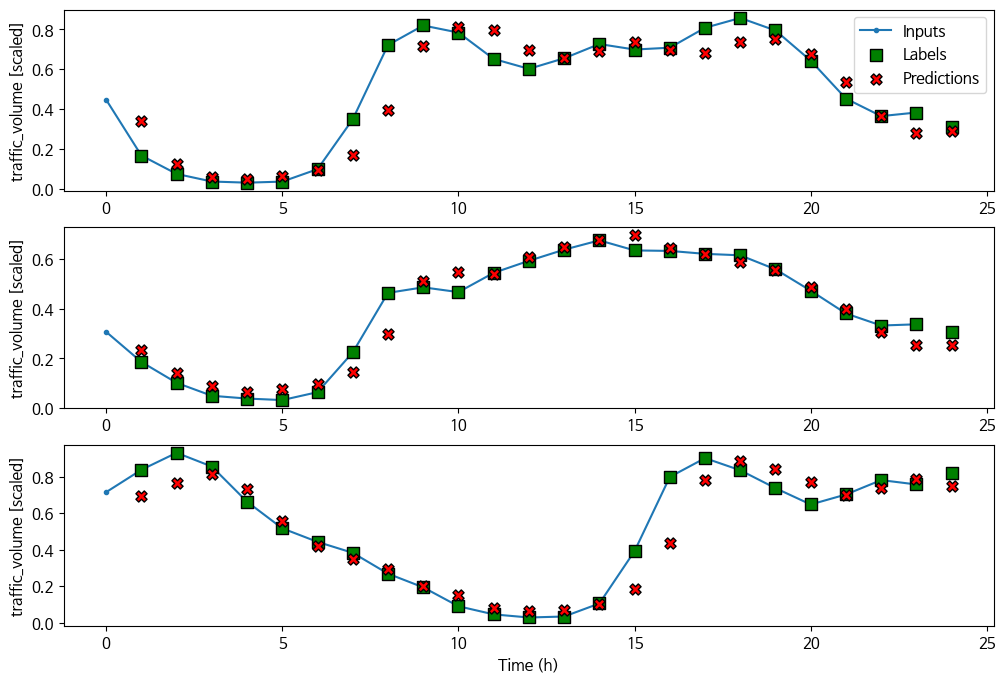

In [ ]:
wide_window.plot(linear)

## 다중 단계 선형 모델 예측
- 가중치를 0으로 초기화
- 훈련 절차가 약간 더 빨리짐
- 모델을 컴파일하고 피팅한 뒤, 평가지표를 ms_val_performance와 ms_performance에 저장

In [ ]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1435 - mean_absolute_error: 0.3128 - val_loss: 0.0452 - val_mean_absolute_error: 0.1790
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0353 - mean_absolute_error: 0.1548 - val_loss: 0.0249 - val_mean_absolute_error: 0.1231
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.1104 - val_loss: 0.0207 - val_mean_absolute_error: 0.1068
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0177 - mean_absolute_error: 0.0973 - val_loss: 0.0194 - val_mean_absolute_error: 0.1000
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0167 - mean_absolute_error: 0.0917 - val_loss: 0.0187 - val_mean_absolute_error: 0.0957
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0162 - mean_absolute_error: 0.0884 - val_loss: 0.0183 - val_mean_absolute_error: 0.0927
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0159 - mean_absolute_error: 0.0863 - v

## 다중 출력 선형 모델
- 현재 시간 단계에 대한 모든 특징을 입력받아 다음 시간 단계의 온도와 교통량에 대한 예측 생성

In [ ]:
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.7038 - mean_absolute_error: 0.7228 - val_loss: 0.1760 - val_mean_absolute_error: 0.3404
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1268 - mean_absolute_error: 0.2913 - val_loss: 0.0910 - val_mean_absolute_error: 0.2484
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0715 - mean_absolute_error: 0.2200 - val_loss: 0.0526 - val_mean_absolute_error: 0.1880
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0414 - mean_absolute_error: 0.1660 - val_loss: 0.0313 - val_mean_absolute_error: 0.1443
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0251 - mean_absolute_error: 0.1274 - val_loss: 0.0202 - val_mean_absolute_error: 0.1150
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0168 - mean_absolute_error: 0.1024 - val_loss: 0.0143 - val_mean_absolute_error: 0.0959
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0125 - mean_absolute_error: 0.0868 - v

## 심층 신경망 구현
- 활성화 함수는 더 나은 경사 전파
- 더 효율적인 계산, 경사 소실 문제 감소, 빠른 학습 속도, 비선형성, 희소성 등에 이점 제

### 단일 단계 모델

In [ ]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0481 - mean_absolute_error: 0.1380 - val_loss: 0.0043 - val_mean_absolute_error: 0.0493
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0043 - mean_absolute_error: 0.0481 - val_loss: 0.0028 - val_mean_absolute_error: 0.0394
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0408 - val_loss: 0.0024 - val_mean_absolute_error: 0.0355
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0384 - val_loss: 0.0022 - val_mean_absolute_error: 0.0343
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0026 - mean_absolute_error: 0.0363 - val_loss: 0.0026 - val_mean_absolute_error: 0.0400
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0350 - val_loss: 0.0020 - val_mean_absolute_error: 0.0317
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0345 - 

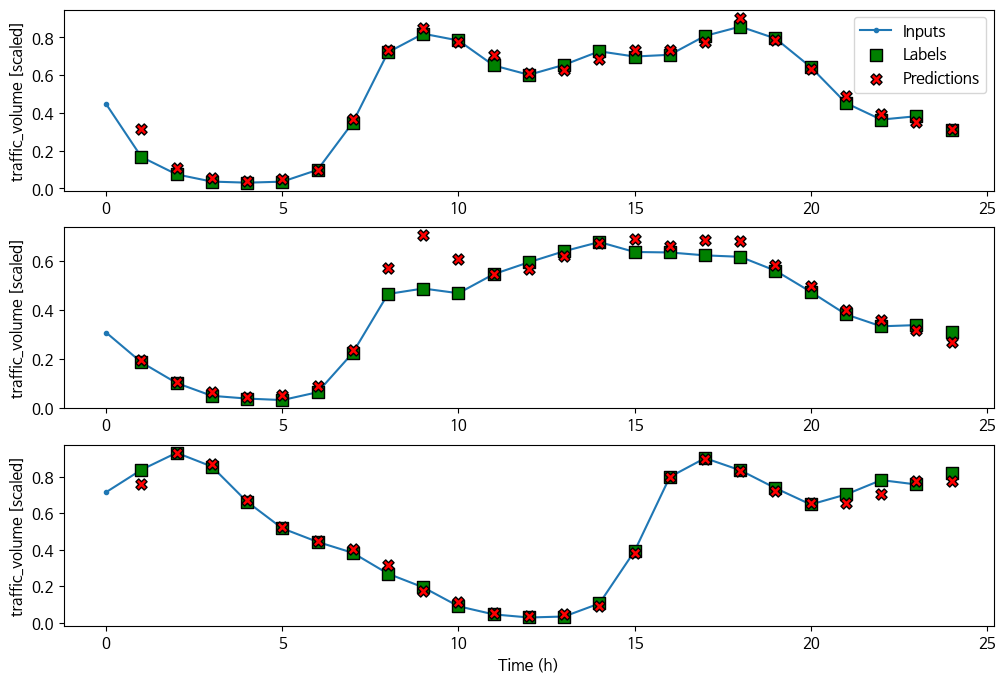

In [ ]:
wide_window.plot(dense)

- 기존 단일 단계 모델과 결과 비교

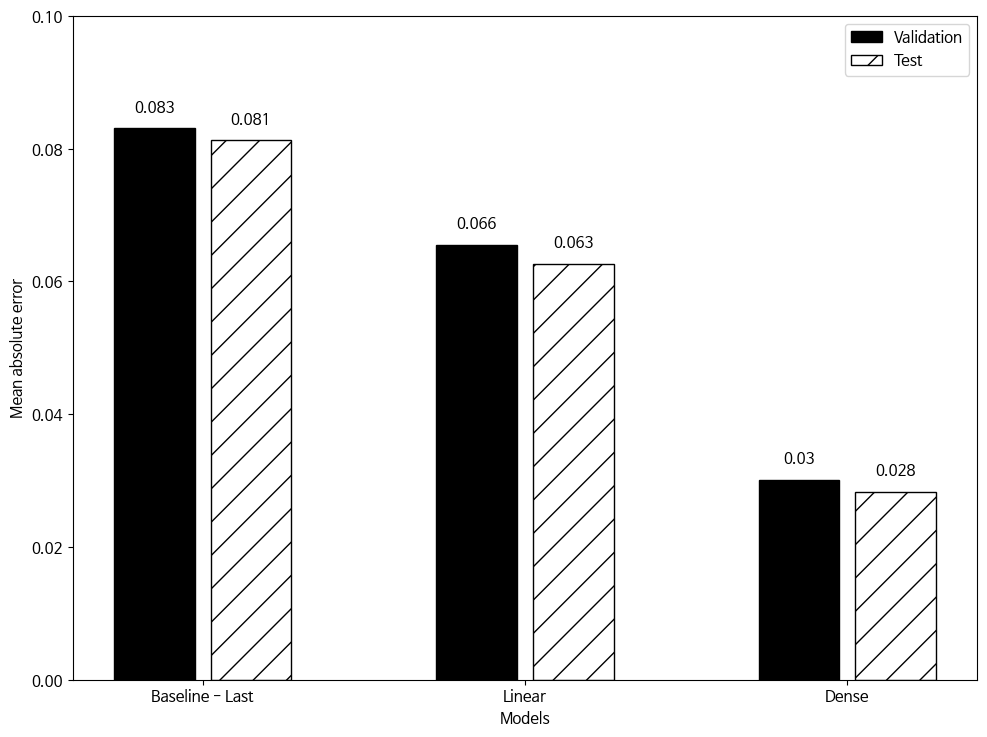

In [ ]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

### 다중 단계 모델

In [ ]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0676 - mean_absolute_error: 0.1767 - val_loss: 0.0164 - val_mean_absolute_error: 0.0815
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0142 - mean_absolute_error: 0.0777 - val_loss: 0.0155 - val_mean_absolute_error: 0.0797
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0137 - mean_absolute_error: 0.0772 - val_loss: 0.0161 - val_mean_absolute_error: 0.0784
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0135 - mean_absolute_error: 0.0770 - val_loss: 0.0154 - val_mean_absolute_error: 0.0853
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0135 - mean_absolute_error: 0.0777 - val_loss: 0.0150 - val_mean_absolute_error: 0.0845
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0132 - mean_absolute_error: 0.0768 - val_loss: 0.0150 - val_mean_absolute_error: 0.0756
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0132 - mean_absolute_error: 0.0769 

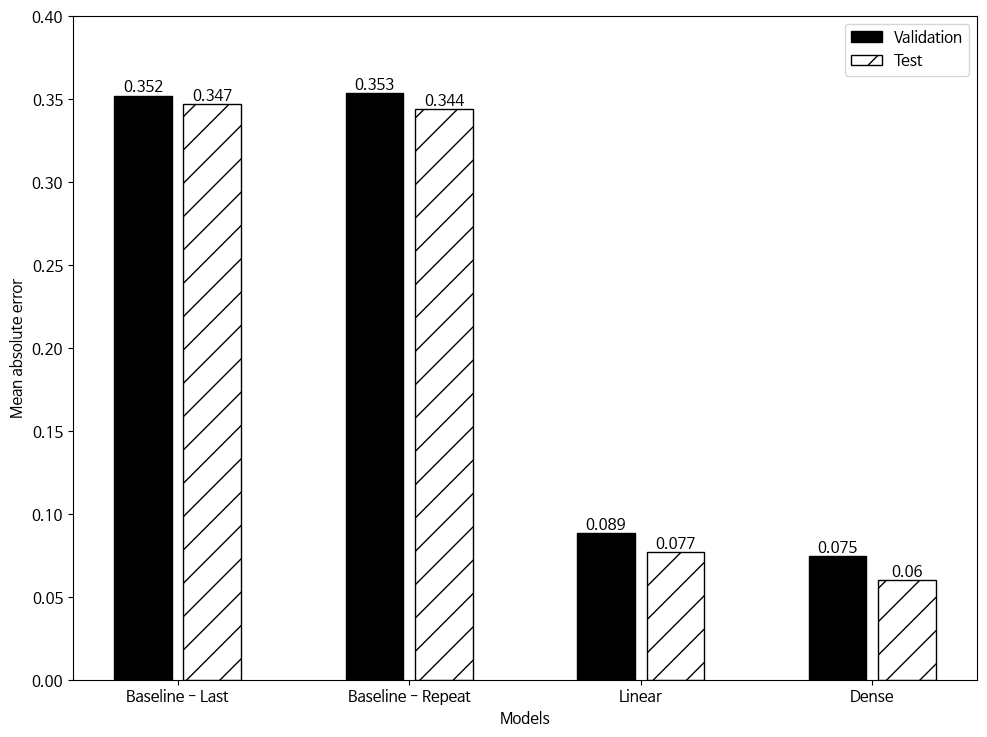

In [ ]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.show()

### 다중 출력 모델

In [ ]:
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0410 - mean_absolute_error: 0.1239 - val_loss: 0.0028 - val_mean_absolute_error: 0.0334
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0343 - val_loss: 0.0019 - val_mean_absolute_error: 0.0289
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0022 - mean_absolute_error: 0.0299 - val_loss: 0.0018 - val_mean_absolute_error: 0.0280
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0020 - mean_absolute_error: 0.0286 - val_loss: 0.0015 - val_mean_absolute_error: 0.0254
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0265 - val_loss: 0.0017 - val_mean_absolute_error: 0.0280
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0268 - val_loss: 0.0012 - val_mean_absolute_error: 0.0228
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0253

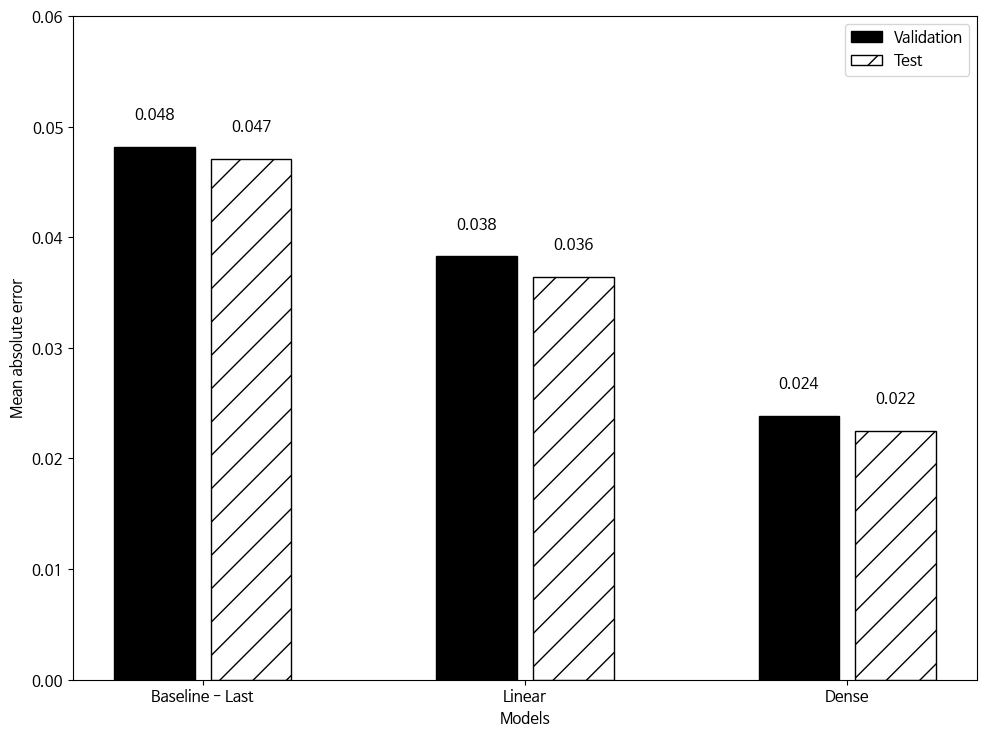

In [ ]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.show()

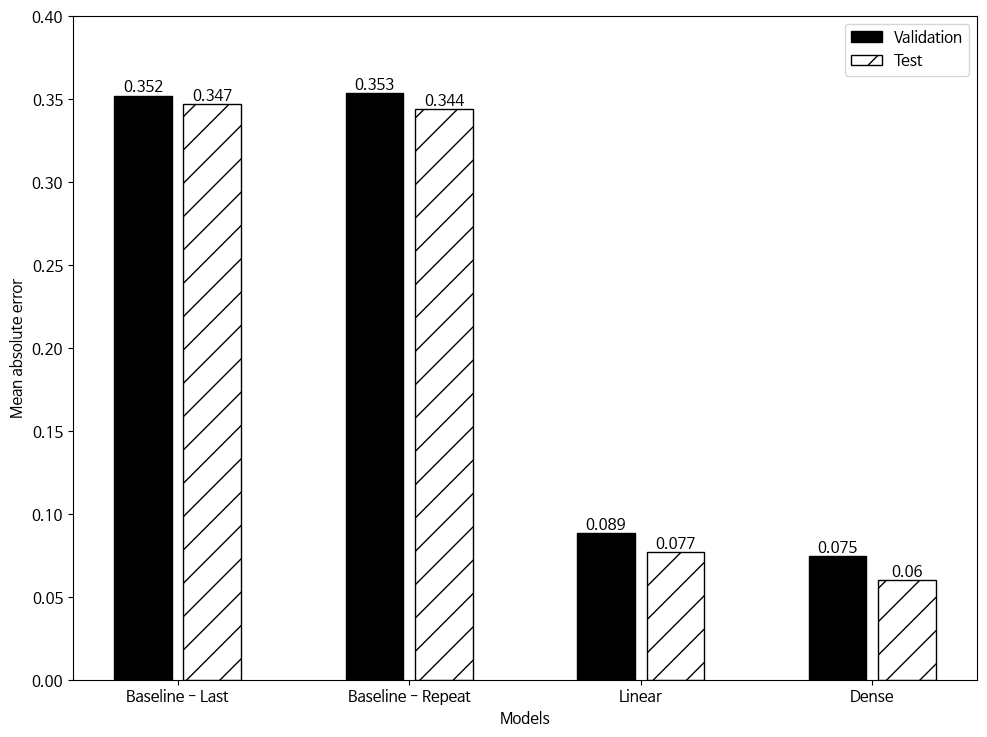

In [ ]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.show()